In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.container { font-size:16px !important; }</style>"))

import numpy as np 
import matplotlib.pyplot as plt 

from matplotlib import rcParams
#rcParams['font.family'] = 'sans'
#rcParams['font.sans-serif'] = ['Tahoma']
rcParams['font.size'] = 16
#rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

import emcee 
import corner
from astropy.io import fits 

# Estimating longitudinal magnetic fields in solar atmosphere

During one of our previous hands-ons and in the homework we analyzed a HINODE datacube and tried to infer some velocities and the temperatures using some simple diagnostics. Today we are going to use another simple diagnostic to estimate the magnetic field! We just reviewed Zeeman effect so we should be ready! 

Let's first see how the polarization looks like and try to "see" the magnetic field with our own eyes, before conducting any inference. So, open the cube, visualize and see how it looks like. 

In [9]:
stokes = fits.open("/home/milic/data/scan_20141104_061202.fits")[0].data
print(stokes.shape)

(384, 383, 4, 112)


In [5]:
stokes =fits.open('/dat/xenosh/MiHi_Fe_I_plage/TimeSeries/1/stokes.fits')[0].data
ll = fits.open('/dat/xenosh/MiHi_Fe_I_plage/TimeSeries/1/stokes.fits')[1].data

Let's recall what the axis mean: 

0 - y (along the slit) 

1 - x (perpendicular to the slit) 

2 - Polarization state (I,Q,U,V), so it's always 4 

3 - Wavelength. Always 112, grid provided by the HINODE calibration (see below, if you want more details how to obtain that, ping me!)

Text(0.5, 1.0, 'Continuum intensity map')

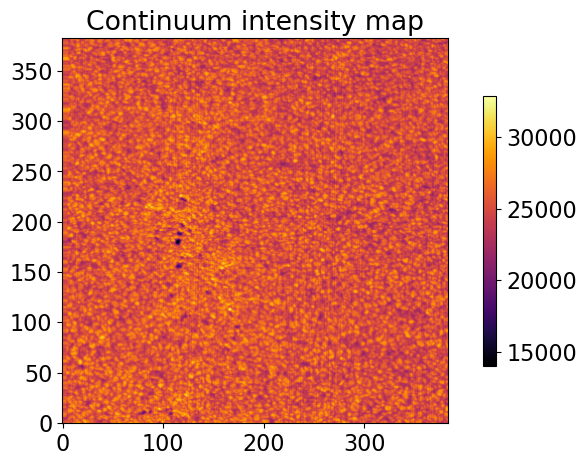

In [10]:
# Let's plot a continuum image:

plt.figure(figsize=[9,5])
plt.imshow(stokes[:,:,0,0].T,origin='lower',cmap='inferno')
plt.colorbar(shrink=0.7)
plt.title("Continuum intensity map")

This was just one Stokes component let's plot all 4! 

In [54]:
I_qs = np.mean(stokes[:,:,0,-10:])
print (I_qs)
stokes /= I_qs

25304.54024015448


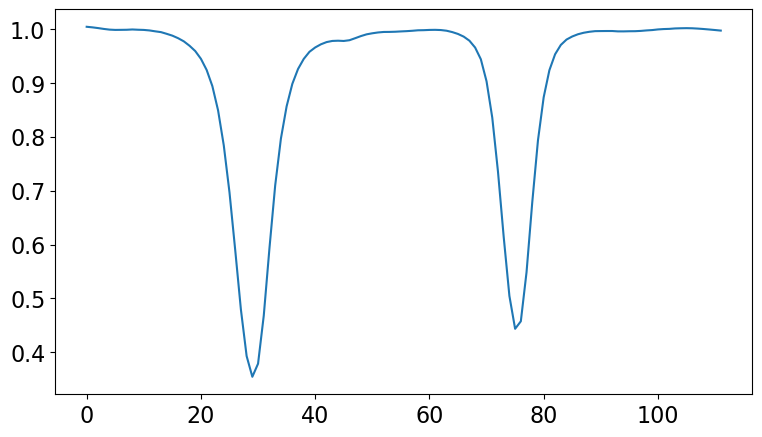

In [55]:
# To figure out which wavelength we should plot, let's sketch our average spectrum:

mean_spectrum = np.mean(stokes[:,:,0,:],axis=(0,1))
plt.figure(figsize=[9,5])
plt.plot(mean_spectrum)

Cool, so our line core is around 30 for the first line and around 75 for the second line. You can "ZOOM IN" to test this if you feel like. 

I will plot intensity I, Stokes Q and U in the line core and Stokes V a little bit off line core.

Text(0.5, 1.0, 'Stokes V')

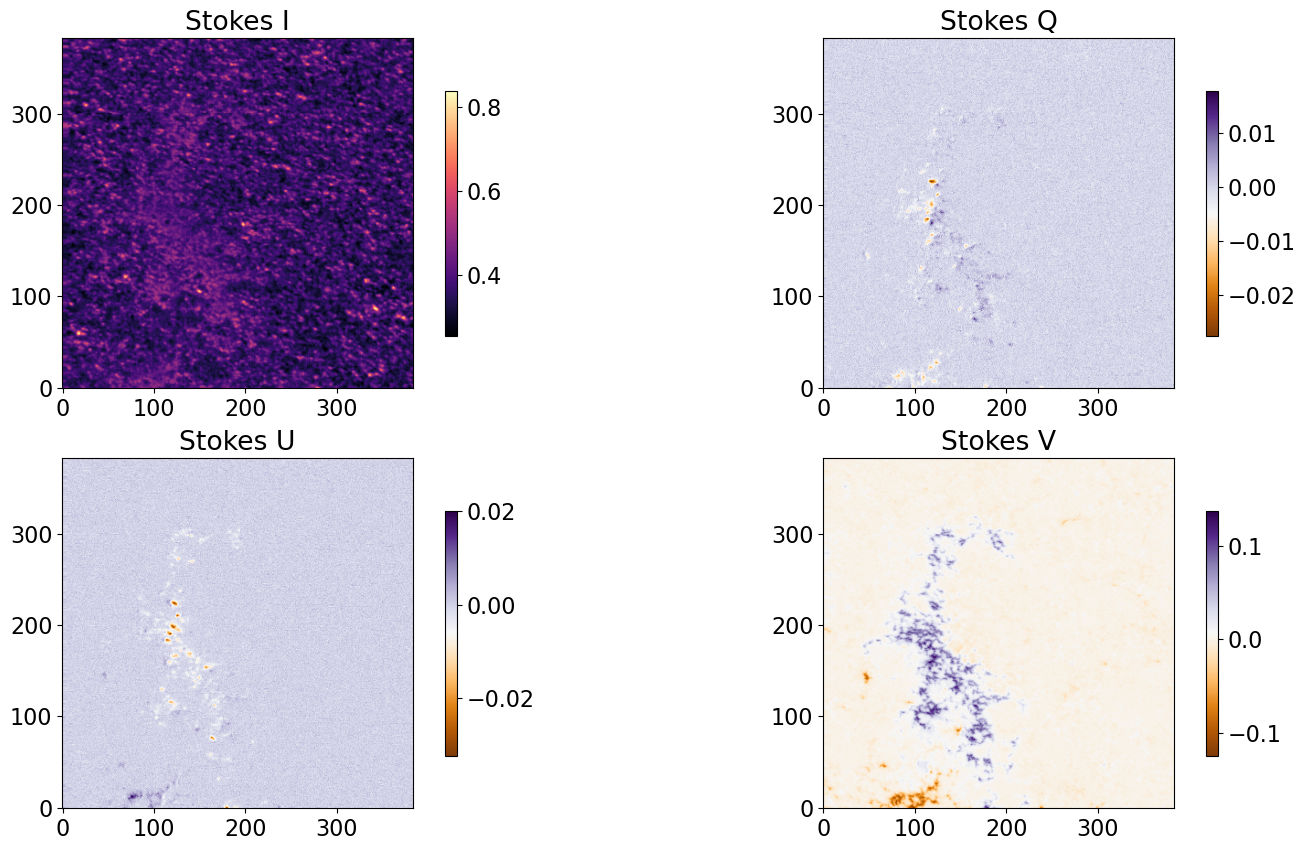

In [56]:
plt.figure(figsize=[18,10])
plt.subplot(221)
plt.imshow(stokes[:,:,0,30].T,origin='lower',cmap='magma')
plt.colorbar(shrink=0.7)
plt.title("Stokes I")
plt.subplot(222)
plt.imshow(stokes[:,:,1,30].T,origin='lower',cmap='PuOr')
plt.colorbar(shrink=0.7)
plt.title("Stokes Q")
plt.subplot(223)
plt.imshow(stokes[:,:,2,30].T,origin='lower',cmap='PuOr')
plt.colorbar(shrink=0.7)
plt.title("Stokes U")
plt.subplot(224)
plt.imshow(stokes[:,:,3,33].T,origin='lower',cmap='PuOr')
plt.colorbar(shrink=0.7)
plt.title("Stokes V")

Much nicer! Now a nice thing to do would be normalize these quantities somehow and plot again. Typically we normalize things using quite Sun continuum intensity:

Nice! Now we can talk a little bit about the distribution of these signals.

And maybe pick a pixel to plot the spectrum  from?

Text(0.5, 1.0, 'Stokes V')

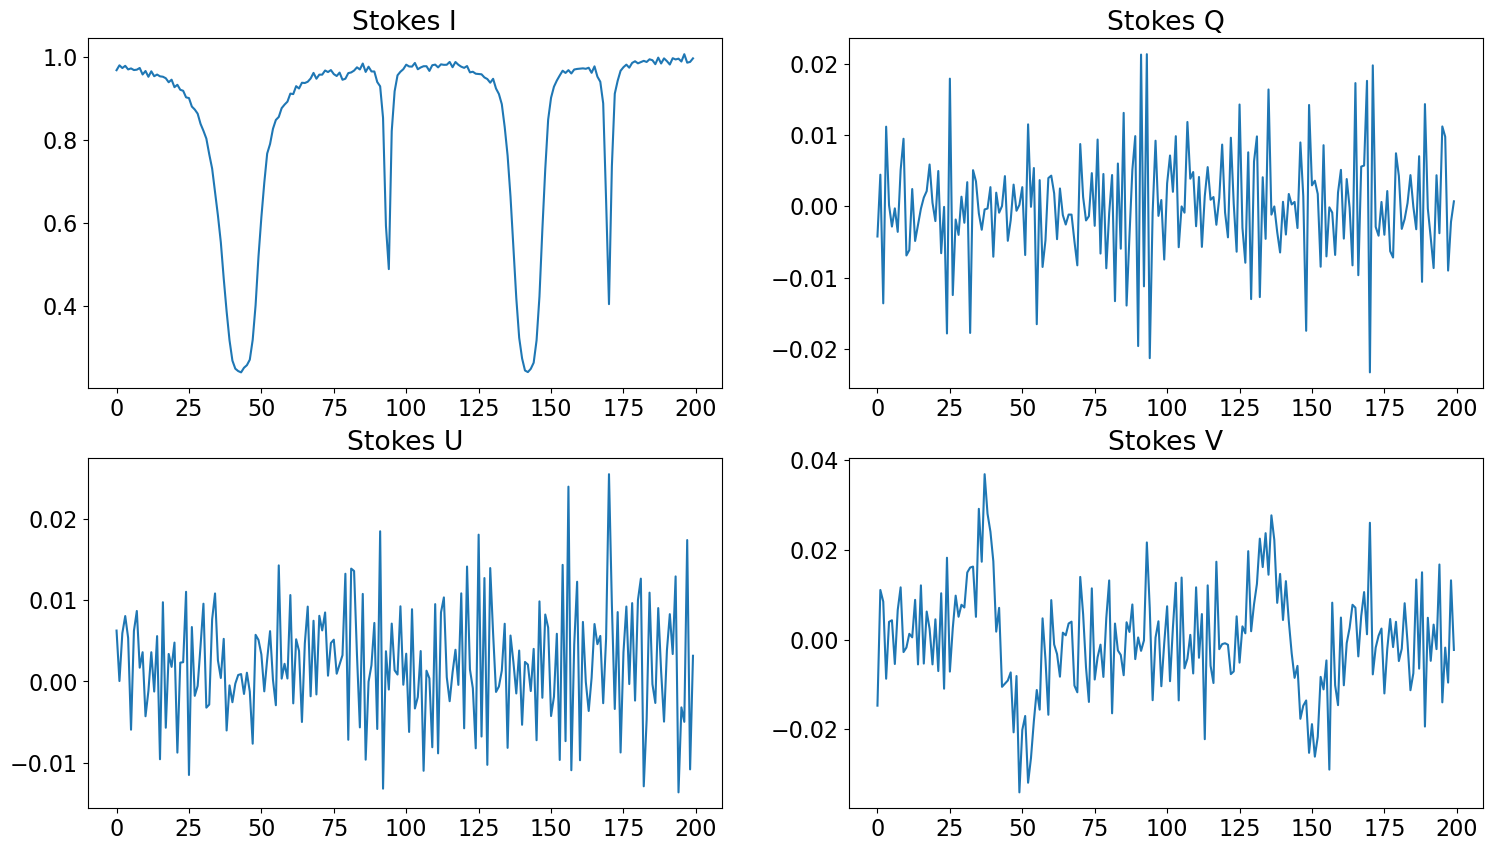

In [9]:
#i = 120
#j = 150
plt.figure(figsize=[18,10])
plt.subplot(221)
plt.plot(stokes[i,j,0,:])
plt.title("Stokes I")
plt.subplot(222)
plt.plot(stokes[i,j,1,:])
plt.title("Stokes Q")
plt.subplot(223)
plt.plot(stokes[i,j,2,:])
plt.title("Stokes U")
plt.subplot(224)
plt.plot(stokes[i,j,3,:])
plt.title("Stokes V")


In [58]:
# So, to make wavelength, let's do something like this. 
NL = 112 
ll = np.linspace(0,NL-1,NL)
ll = 6302.08 + (ll-56.5)*0.0215

Our goal for today is to fit some data. We are going to use physically motivated model to relate Stokes I and Stokes V and to obtain longitudinal magnetic field. Weak field approximation implies that: 

$$V = -4.69\times 10^{-13} \frac{dI}{d\lambda}\lambda^2 g_L B_{\rm los} $$

Where $g_L$ is the Lande factor of the line, $B_n$ is transversal magnetic field and $\lambda$ is the wavelength of the line. Since we are talking about a very small range of wavelenghts, we can use line center wavelenght here. Let's take some HINODE plage data and try to infer some magnetic fields ;-)

As we said V is directly propotional to $dI/d\lambda$. So I can fit V to $dI/d\lambda$!!!! For starters using just matrix inversion. Note that we have to treat the two lines separately as they have different lande factors. 

Text(0, 0.5, 'V')

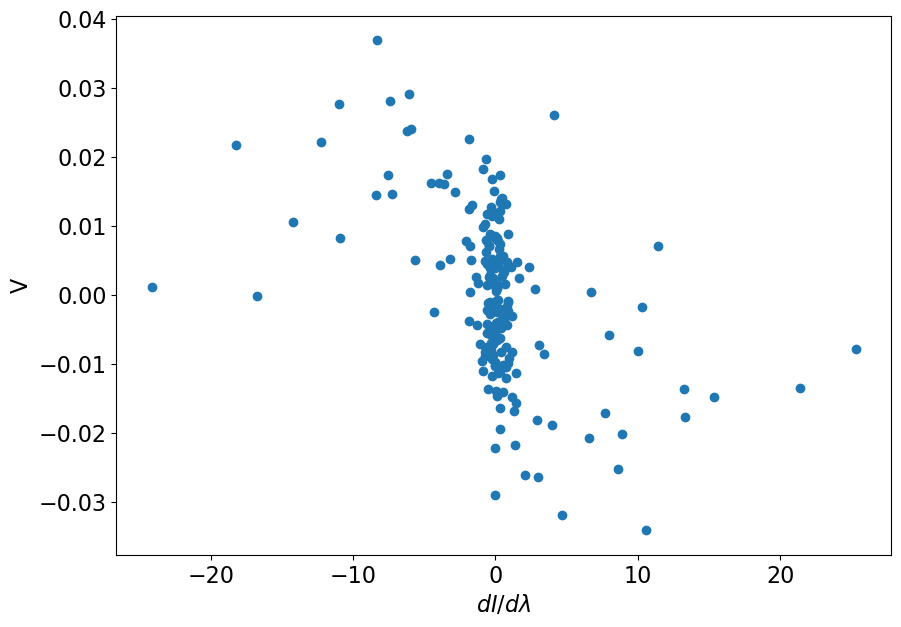

In [6]:
# Let's plot derivative of dI / dl vs Stokes V for one of the pixels, let's say the one above:
i = 45
j = 26
dI_dl = np.gradient(stokes[i,j,0]) / np.gradient(ll)
V = stokes[i,j,3]
plt.figure(figsize=[10,7])
plt.plot(dI_dl,V,'o')
plt.xlabel("$dI/d\lambda$")
plt.ylabel("V")

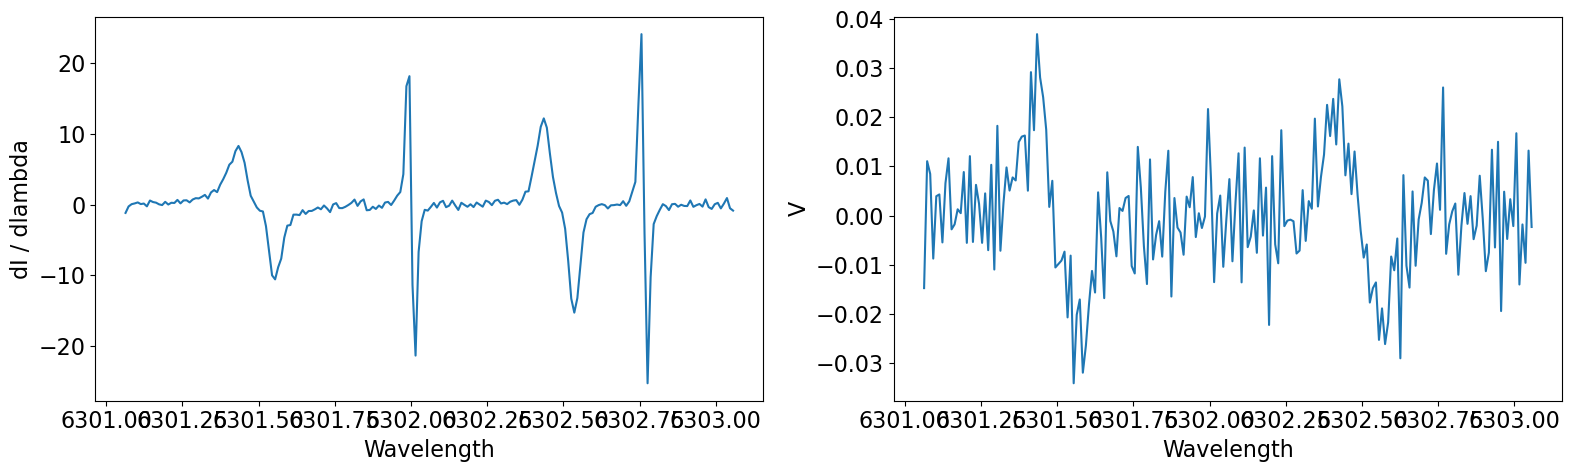

In [7]:
plt.figure(figsize=[16,5])
plt.subplot(121)
plt.plot(ll,-dI_dl)
plt.xlabel("Wavelength")
plt.ylabel("dI / dlambda")
plt.subplot(122)
plt.plot(ll,V)
plt.xlabel("Wavelength")
plt.ylabel("V")
plt.tight_layout()


Text(0, 0.5, 'V')

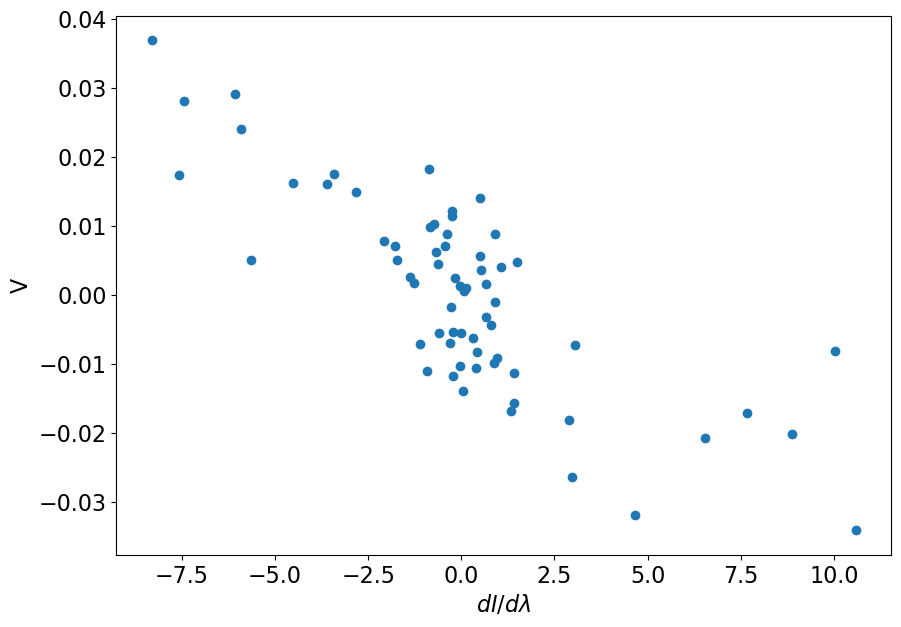

In [10]:
# Let's plot derivative of dI / dl vs Stokes V for one of the pixels, let's say the one above:
#i = 120
#j = 150
dI_dl = np.gradient(stokes[i,j,0]) / np.gradient(ll)
V = stokes[i,j,3]
plt.figure(figsize=[10,7])
plt.plot(dI_dl[10:75],V[10:75],'o')
plt.xlabel("$dI/d\lambda$")
plt.ylabel("V")

### Without calculating anything, which sign is the magnetic field? (Scroll up to look at the equation).

Good, now fitting time! 

We want to fit this with a linear function now, that is basically something like this:
$$k x +n =y $$
Or written as a matrix equation, keep in mind $k$ and $n$ are unknowns...
$$(\vec{x} , \vec{1})(k,n)^T = y$$ 

We have an overdetermined system: 
$$ a x = b$$ 
We are solving it using pseudoinverse! 

In [62]:
#Let's do the fit
# We are also considering first line only:
ND = 40
a = np.zeros([ND,2])
a[:,0] = dI_dl[10:50]
a[:,1] = 1.0
b = V[10:50]

a_inv = np.linalg.pinv(a)

p = np.linalg.inv((a_inv @ a))@ (a_inv @ b)
print (p)

[0.00552877 0.00028358]


Let's see if this makes sense

Text(0, 0.5, 'V')

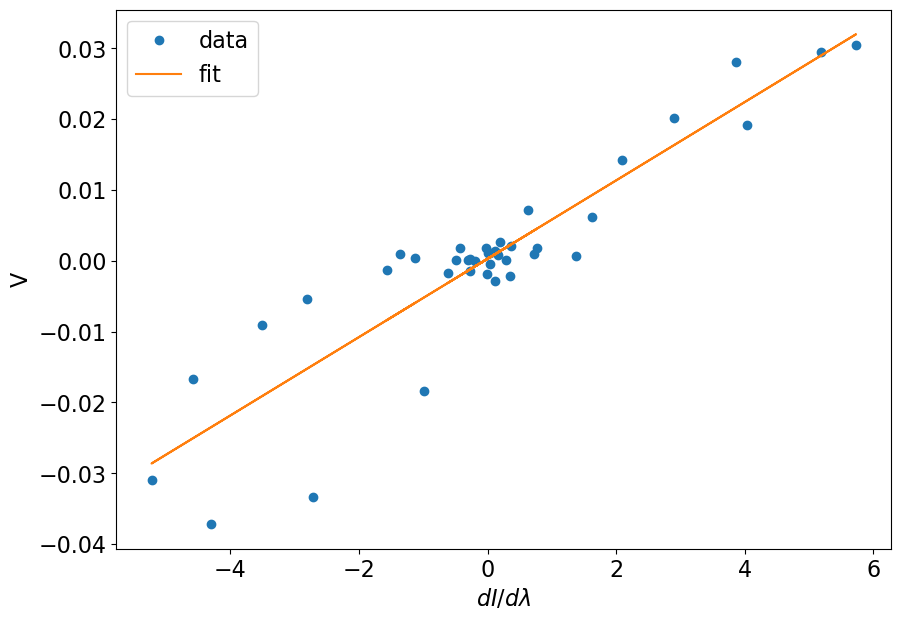

In [63]:
plt.figure(figsize=[10,7])
plt.plot(dI_dl[10:50],V[10:50],'o',label='data')
plt.plot(dI_dl[10:50],dI_dl[10:50]*p[0]+p[1],label='fit')
plt.legend()
plt.xlabel("$dI/d\lambda$")
plt.ylabel("V")

Now let's estimate the magnetic field from this. Remember that $k = - 4.69\times 10^{-13} \times B_{\rm los} \lambda_0^2 g_l$

In [64]:
B = -p[0] / 4.69E-13 / 6301.5**2.0 / 1.67
print (B)

-177.76722945284632


Good! We actually estimated magnetic field. Now let's do this for the whole map :-)

In [66]:
%%time
def estimate_B(dI_dl,V,llambda0,g):
    ND = len(V)
    a = np.zeros([ND,2])
    a[:,0] = dI_dl[:]
    a[:,1] = 1.0
    b = V[:]

    a_inv = np.linalg.pinv(a)

    p = np.linalg.inv((a_inv @ a))@ (a_inv @ b)
    
    B = -p[0] / 4.69E-13 / llambda0**2.0 / g
    return B
    
NX = stokes.shape[0]
NY = stokes.shape[1]

B = np.zeros([NX,NY])

for i in range (0,NX):
    for j in range(0,NY):
        dI_dl =  np.gradient(stokes[i,j,0,10:50]) / np.gradient(ll[10:50])
        B[i,j] = estimate_B(dI_dl,stokes[i,j,3,10:50],6301.5,1.67)

CPU times: user 5.72 s, sys: 0 ns, total: 5.72 s
Wall time: 5.7 s


In [67]:
B.shape

(384, 383)

Looks reasonable, let's plot what we got! :-) 

Text(0.5, 1.0, 'Longitudinal Magnetic Field')

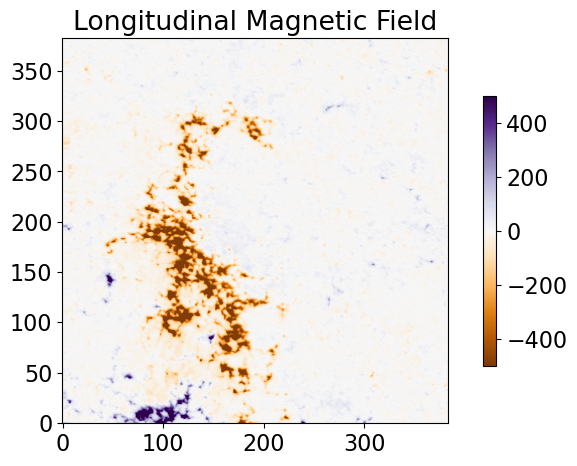

In [68]:
# Let's plot the magnetic field

plt.figure(figsize=[9,5])
plt.imshow(B.T,origin='lower',cmap='PuOr',vmin=-500,vmax=500)
plt.colorbar(shrink=0.7)
plt.title("Longitudinal Magnetic Field")

Now a good question is ... what are our measurement uncertainties!!!! Ok, let's learn that MCMC. For that we will need to explicitly define our likelyhood, prior and posterior. Let's do that. 

In [11]:
#Likelyhood, depends on the function parameters (that can change) and the observations (that are fixed). For convenience we will work
# in log scale

def ln_prior(params):
    # all parameters equally likely
    return 0.

def ln_like(params, x, y, error):
    
    # Remember that gaussian is : p(x) = 1./(sqrt(2 pi) sigma ) exp(-x^2/2sigma^2)
    
    #What model predicts: (error == sigma)
    y_model = params[0] * x + params[1]
    
    chi2 = ((y_model - y) / error)**2
    
    return np.sum((-0.5 * chi2) - 0.5*np.log(2*np.pi) - np.log(error)) # I am making it depend on errors in purpose

def ln_post(params, x, y, error):
    
    lnprior_val = ln_prior(params)
    
    if ~np.isfinite(lnprior_val):
        return lnprior_val
    else:           
        lnlike_val = ln_like(params, x, y, error)
        return lnprior_val + lnlike_val

So now we are sampling. What are we sampling? The posterior, rright! 

In [41]:
ndim = 2 # because we have two parameters 
nwalkers = 20 # this is number of random points

i = 45
j = 26
x_data = np.gradient(stokes[i,j,0,10:75]) / np.gradient(ll[10:75])
y_data = stokes[i,j,3,10:75]

errors = np.zeros(65)

errors[:] = 1E-2

starting_params = np.random.uniform(0, 1, ndim*nwalkers).reshape((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post, args=[x_data,y_data,errors])

num_steps = 10000
pos, prob, state = sampler.run_mcmc(starting_params, num_steps)

In [14]:
print(sampler.chain.shape)

(20, 10000, 2)


(-0.005, 0.005)

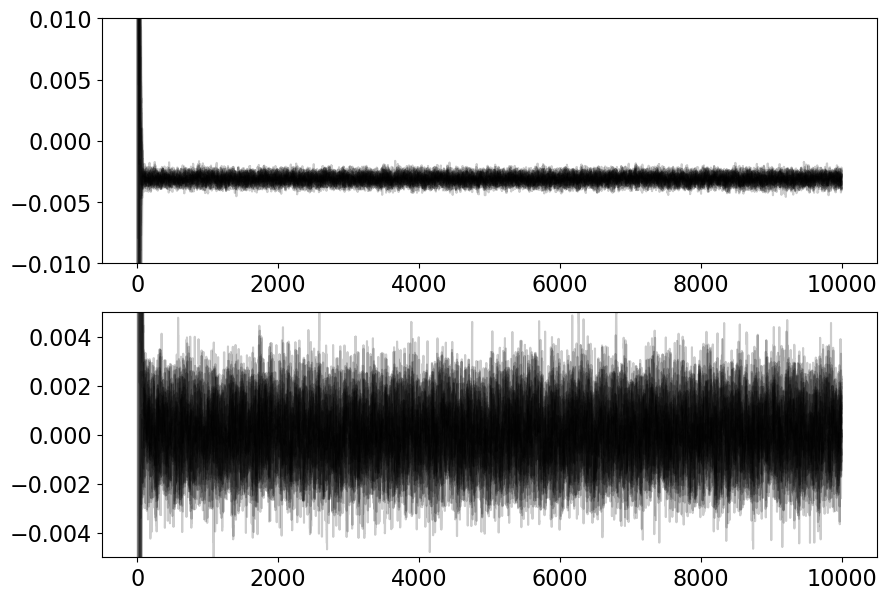

In [25]:
plt.figure(figsize=[10,7])
plt.subplot(211)
plt.plot(sampler.chain[:, :, 0].T, '-k', alpha=0.2)
plt.ylim([-0.01,0.01])
plt.subplot(212)
plt.plot(sampler.chain[:, :, 1].T, '-k', alpha=0.2)
plt.ylim([-0.005,0.005])

<Figure size 1200x1000 with 0 Axes>

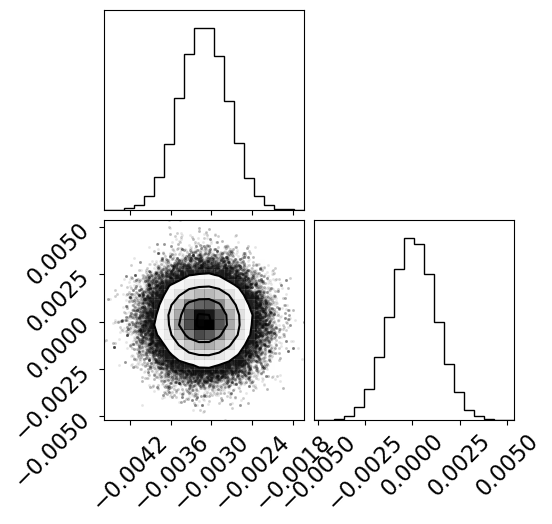

In [26]:
plt.figure(figsize=[12,10])
figure = corner.corner(sampler.flatchain[10000:])

Recall that marginalization works like this: 
$$p(k|D) = \int_0^{\infty}p(k,n|D) dn$$

Let's use these distributions to calculate some properties of our inferred parameter. Keep in mind we are only interested in the slope and not in the intercept so we are going to marginalize over the intercept. Thanks to sampling method marginalization is just ignoring parameters we are marginalizing over. 

So:

In [42]:
params = np.squeeze(sampler.flatchain[10000:])
print (params.shape)

(190000, 2)


(array([2.5000e+01, 4.7000e+01, 2.6400e+02, 8.9600e+02, 2.3290e+03,
        5.5360e+03, 1.1026e+04, 1.8700e+04, 2.6068e+04, 3.0477e+04,
        3.0449e+04, 2.5780e+04, 1.8318e+04, 1.1286e+04, 5.3590e+03,
        2.3330e+03, 8.2600e+02, 1.8100e+02, 9.3000e+01, 7.0000e+00]),
 array([-0.00458049, -0.00443335, -0.00428621, -0.00413907, -0.00399192,
        -0.00384478, -0.00369764, -0.0035505 , -0.00340335, -0.00325621,
        -0.00310907, -0.00296193, -0.00281479, -0.00266764, -0.0025205 ,
        -0.00237336, -0.00222622, -0.00207908, -0.00193193, -0.00178479,
        -0.00163765]),
 <BarContainer object of 20 artists>)

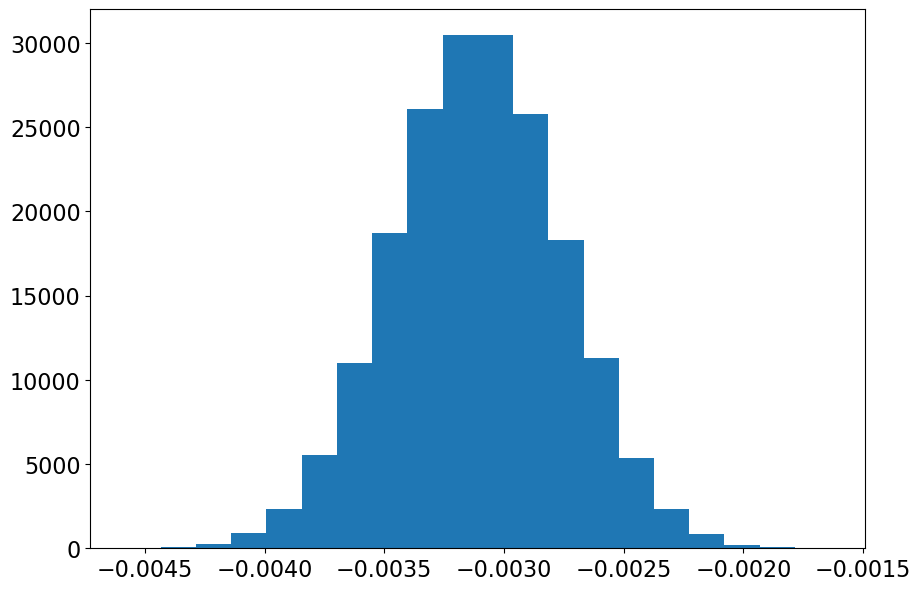

In [28]:
plt.figure(figsize=[10,7])
plt.hist(params[:,0],bins=20)

Makes sense, we saw this up there already. What is now value yo ushould put in your paper? Well, most people would tell you that specifying a confidence interval is good enough. Here I want a 95% confidence interval, say, so I will calculate so called percentiles. I want limits that contain central 95% of my distribution. 

In [43]:
lower = np.percentile(params[:,0],16)
median = np.percentile(params[:,0],50.)
upper = np.percentile(params[:,0],84)

# Note that magnetic field is directly proportional to the slope
# otherwise I should have used magnetic field as a parameter, directly in the fitting

B = -median / 4.69E-13 / 6301.5**2.0 / 1.67
B_u = -upper / 4.69E-13 / 6301.5**2.0 / 1.67
B_l = -lower / 4.69E-13 / 6301.5**2.0 / 1.67
print (B,B_u-B,B_l-B)

100.25962044958779 -11.191465753570213 11.158344985699173


So our paper would say something like: 

$$ B = -178_{-4.3}^{+4.3}\,\mathrm{G} $$

Go now! Do this for every pixel! (You will see it is hard). But we can do it using the approach above. 

Btw, these are always nice to plot:

In [30]:
#Take a sample of straight lines:
indices = np.arange(len(params[:,0]))
random_sample = np.random.choice(indices,200)
to_plot = params[random_sample,:]
print (to_plot.shape)


(200, 2)


Text(0, 0.5, 'V')

<Figure size 1000x700 with 0 Axes>

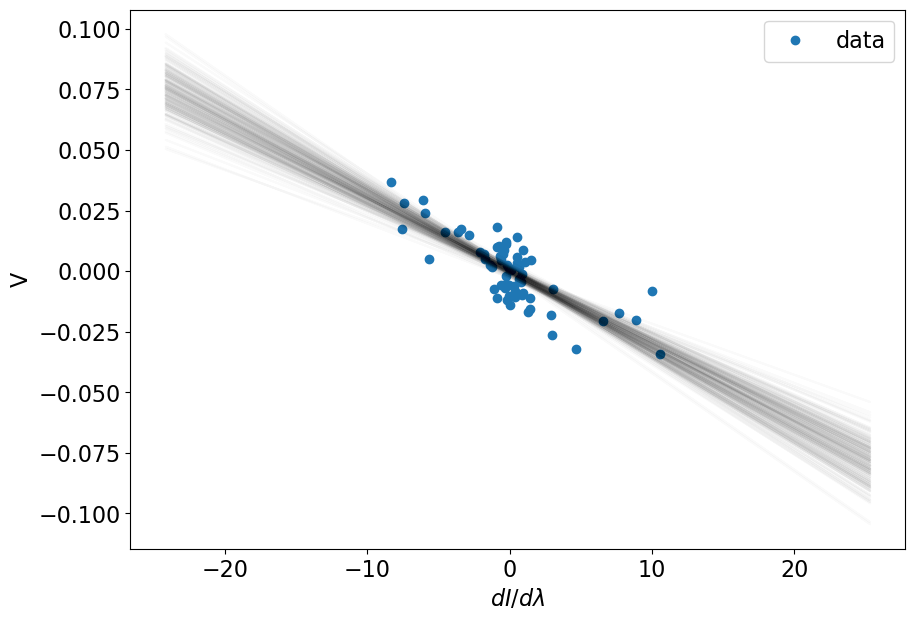

In [31]:
median_slope = np.percentile(params[:,0],50)
median_intercept = np.percentile(params[:,0],50)

plt.figure(figsize=[10,7])
plt.figure(figsize=[10,7])
plt.plot(dI_dl[10:75],stokes[i,j,3,10:75],'o',label='data')
#plt.plot(dI_dl,dI_dl*median_slope+median_intercept,linewidth=4,label='fit')
for s in range (0,200):
    plt.plot(dI_dl,dI_dl*to_plot[s,0]+to_plot[s,1],'-k',alpha=0.02)
plt.legend()
plt.xlabel("$dI/d\lambda$")
plt.ylabel("V")

Cool, so, so far we have managed to: 

- Extract a Stokes profile from HINODE cube and see that Stokes V really does look like derivative of Stokes I with wavelength
- Fit a straight line to $V(I')$ dependency, using simple linear system solution. 
- Use a Markov Chain Monte Carlo sampler to sample posterior and perform marginalization and uncertainty esimation.

Now, let's, address noise in more detail. How to infer it? 

(Discuss a bit)

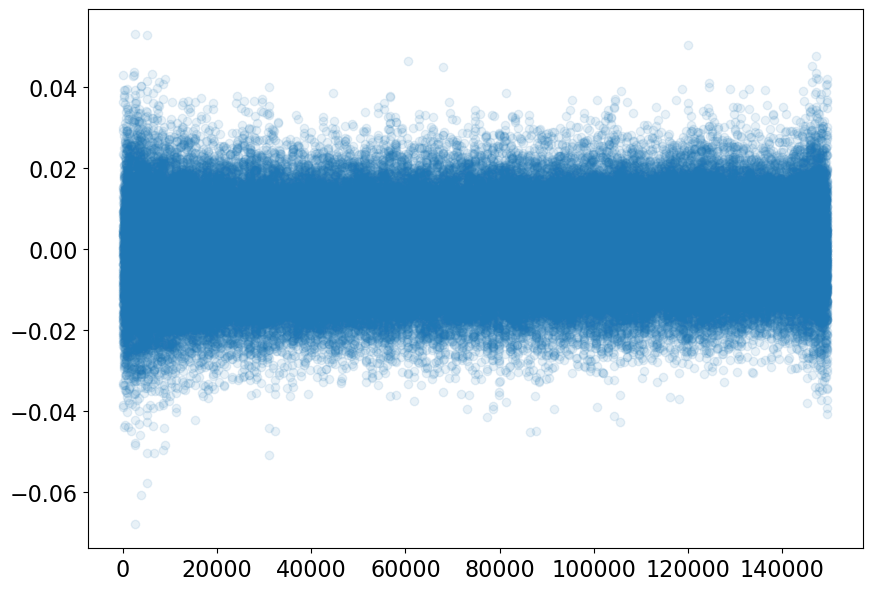

In [32]:
# Yes we can do that: 

V_continuum = stokes[:,:,3,-10:].flatten()

plt.figure(figsize=[10,7])
plt.plot(V_continuum,'o',alpha=0.1)

(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0000e+00, 3.0000e+00, 1.0000e+01,
        8.0000e+00, 1.4000e+01, 2.3000e+01, 5.7000e+01, 9.4000e+01,
        1.9000e+02, 2.8600e+02, 5.3900e+02, 9.0800e+02, 1.4950e+03,
        2.3990e+03, 3.6860e+03, 5.6400e+03, 7.4890e+03, 1.0050e+04,
        1.2180e+04, 1.3994e+04, 1.5288e+04, 1.5194e+04, 1.4117e+04,
        1.2469e+04, 1.0179e+04, 7.7680e+03, 5.5660e+03, 3.8130e+03,
        2.5010e+03, 1.5290e+03, 8.8400e+02, 5.2700e+02, 3.2500e+02,
        1.6300e+02, 1.0700e+02, 5.8000e+01, 3.8000e+01, 2.2000e+01,
        1.2000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([-6.77208230e-02, -6.53045843e-02, -6.28883456e-02, -6.04721069e-02,
        -5.80558681e-02, -5.56396294e-02, -5.32233907e-02, -5.08071520e-02,
        -4.83909133e-02, -4.59746746e-02, -4.35584359e-02, -4.11421972e-02,
        -3.87259585e-02, -3.63097198e-02, -3.38934810e-02, -3.14772423e-02,
        -2.906

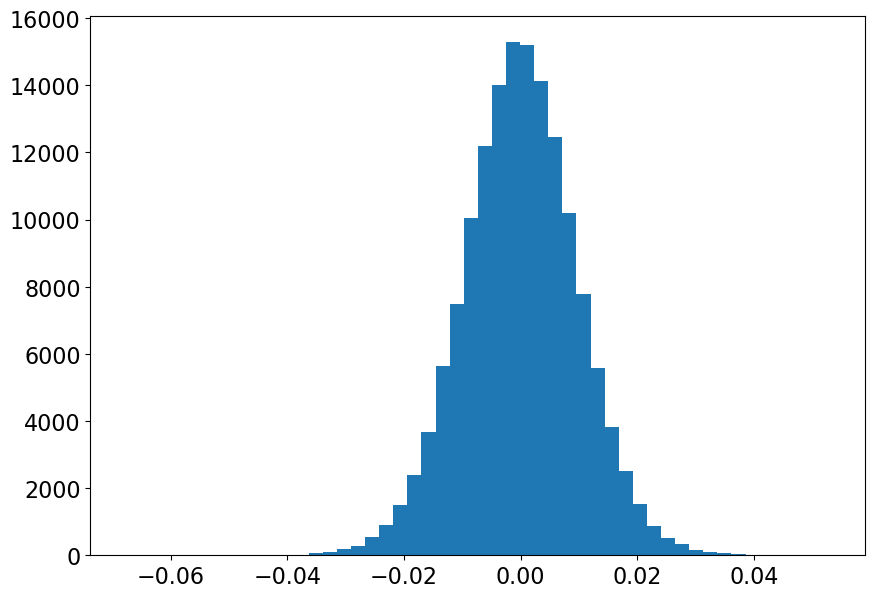

In [33]:
plt.figure(figsize=[10,7])
plt.hist(V_continuum,bins=50)

In [34]:
noise = np.std(V_continuum)
print (noise)

0.009747669607676892


In [35]:
errors[:] = noise

starting_params = np.random.uniform(0, 1, ndim*nwalkers).reshape((nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post,
                                args=[x_data,y_data,errors])

# I just want to run :-)
num_steps = 1000
pos, prob, state = sampler.run_mcmc(starting_params, num_steps)

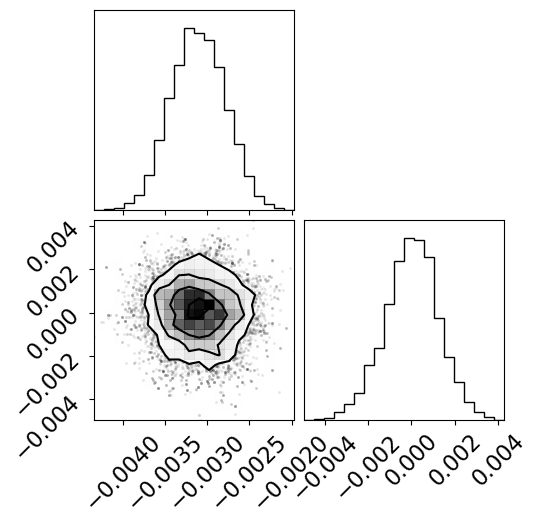

In [36]:
figure = corner.corner(sampler.flatchain[5000:])

In [37]:
params = np.squeeze(sampler.flatchain[5000:])
lower = np.percentile(params[:,0],2.5)
median = np.percentile(params[:,0],50.)
upper = np.percentile(params[:,0],97.5)

B = -median / 4.69E-13 / 6301.5**2.0 / 1.67
B_u = -upper / 4.69E-13 / 6301.5**2.0 / 1.67
B_l = -lower / 4.69E-13 / 6301.5**2.0 / 1.67
print (B,B_u-B,B_l-B)

99.88255963168814 -19.84032806424183 19.78813908875962


Note the uncertanties now! Wow, they decreased. That's right, to perform proper inference you need to know your noise properly! 

An interesting thing to try would be to to spend some time trying to infer the noise itself :-) Let's spend some time doing that ;)

Or if what sounds boring let's try fitting using milne eddington model! 